In [1]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, to_dense_adj

from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

from graph_deep_decoder.baselines import GCNN, GAT, KronAE

# %matplotlib qt

DATASET_PATH = './dataset/temperatures2003_3months.npz'
MAX_SIGNALS = 3
SEED = 0
SAVE = False
PATH = '../results/temperatures/'
FILE_PREF = 'denoise_'

plt.rcParams['image.cmap'] = 'Spectral_r'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

print(device)

cuda:0


## Auxiliary functions

In [2]:
def get_best_err(err):
    median_err = np.median(err, axis=1)
    mean_err = np.mean(err, axis=1)

    best_epochs = np.argmin(median_err, axis=2)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_med_err = np.zeros((len(N_P), len(Exps)))
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_med_err[i, j] = median_err[i, j, best_epochs[i, j]]
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
    return best_mean_err, best_med_err, best_epochs_mean, best_epochs


def plot_noise_err(err, legend, ylabel):
    fig = plt.figure()
    plt.semilogy(N_P, err, linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Normalized noise power',fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim([N_P[0], N_P[-1]])
    # plt.ylim([1e-3, 0.2])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    return fig


def print_err(best_err, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f}'.format(best_err[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs


## Load dataset

Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Contains isolated nodes: False
Is undirected: True
Whole A: Conn Comp: 78


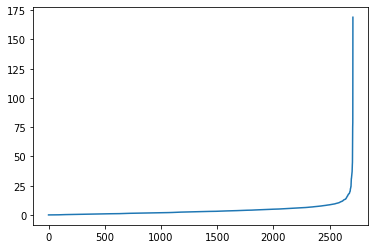

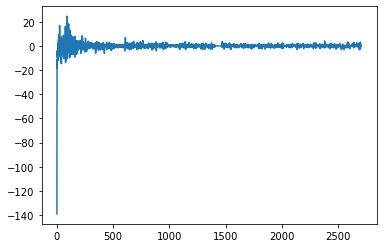

In [3]:
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]

print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Is undirected: {data.is_undirected()}')

A = to_dense_adj(data.edge_index).numpy()[0,:,:]
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('Whole A: Conn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y

plt.figure()
plt.plot(lambdas)
plt.figure()
plt.plot(V.T@labels.numpy())

# A = A[1500:2000,:][:,1500:2000]
# labels = data.y[1500:2000]

G = Graph(A)
G.set_coordinates()

# L = np.diag(np.sum(A, axis=0)) - A
# lambdas, _ = np.linalg.eig(L)
# print('Conn Comp:', np.sum(np.abs(lambdas) <= 1e-3))
S = A

# # plt.figure()
# # nx.draw(nx.from_numpy_matrix(A), node_color=labels)


# plt.figure()
# plt.imshow(S)
# plt.colorbar()
# plt.title('A')


## Using signal associtated with label 0 - As MSE problem

## Set the expetiments

In [4]:
# Get clusters
# clts_nodes = [[250], [350], [80, 500], [300, 500], [300, 1000], [500, 1000],
#               [300], [400], [400, 1000]]

#TRY THESE TOMORROW!
# clts_nodes = [[300, 1000], [400, 1000], [500, 1000], [750, 1000], [1000, 2000], [250, 500, 1500],
#               [300, 1000, 2000], [400, 1000, 2000], [500, 1000, 2000]]

clts_nodes = [[300, 1000], [1000, 2000], [250, 500, 1500],
              [300, 1000, 2000], [500, 1000, 2000]]

# clts_nodes = [[G.N], [G.N]*2, [G.N]*3, [G.N]*4]

clts = []
for i, nodes in enumerate(clts_nodes):
    clts_nodes[i] = nodes + [G.N]*2
    print('Clustering:', clts_nodes[i])
    clt = MultiResGraphClustering(G, clts_nodes[i], clts_nodes[i][0], link_fun='average')
    clts.append(clt)

# # Add more clusters
# clt_aux = [[300], [400], [400, 1000]]
# for nodes in clt_aux:
#     nodes += [G.N]*2
#     clts_nodes.append(nodes)
#     print('Clustering:', nodes)
#     clt = MultiResGraphClustering(G, nodes, nodes[0], link_fun='average')
#     clts.append(clt)

Clustering: [300, 1000, 2708, 2708]
Clustering: [1000, 2000, 2708, 2708]
Clustering: [250, 500, 1500, 2708, 2708]
Clustering: [300, 1000, 2000, 2708, 2708]
Clustering: [500, 1000, 2000, 2708, 2708]


In [5]:
# print(clts_nodes[-1])
# clt = MultiResGraphClustering(G, clts_nodes[-1], clts_nodes[-1][0], link_fun='average')
# clts.append(clt)

## Plot clusrtering

In [6]:
# Plot some clusters 
# plt.figure()
# G.plot_signal(labels.numpy())
# plt.title('Original graph')

# for label in clts[1].labels[:-2]:
#     plt.figure()
#     G.plot_signal(label)
#     plt.title(str(np.max(label)) + ' clusters')

# for label in clts[2].labels[:-2]:
#     plt.figure()
#     G.plot_signal(label)
#     plt.title(str(np.max(label)) + ' clusters')

# for label in clts[4].labels[:-2]:
#     plt.figure()
#     G.plot_signal(label)
#     plt.title(str(np.max(label)) + ' clusters')

# for label in clts[7].labels[:-2]:
#     plt.figure()
#     G.plot_signal(label)
#     plt.title(str(np.max(label)) + ' clusters')

In [20]:
N_P = [0, .1]

# Sigmoid is the best, but with ReLU we outperform the alternative! 

lr = 0.001
loss = nn.SmoothL1Loss 
Exps = [
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': None,
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.ReLU(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        # {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'legend': 'GAT'},
    

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [400, 1000] + [G.N]*2, 'fts': [50]*3 + [1],
        #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [400, 1000] + [G.N]*2, 'fts': [150]*3 + [1],
        #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'legend': 'GD'},



        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [1000, 2000] + [G.N]*2, 'fts': [75]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [500, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [1000, 2000] + [G.N]*2, 'fts': [75]*3 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [500, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},
        

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [1000, 2000] + [G.N]*2, 'fts': [75]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [500, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},
        

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [400, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [1],
        #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'legend': 'GD'},

        ]

# Model parameters
epochs =  1500

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
H = utils.create_filter(S, h_params)
H_norm = H/np.linalg.norm(H)

# Compute needed matrices
for exp in Exps:
    if exp['type'] == '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
        # clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
        idx = clts_nodes.index(exp['nodes'])
        exp['nodes'] = clts[idx].sizes
        exp['Us'] = clts[idx].Us
        exp['As'] = clts[idx].As
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [21]:
n_signals = 10

x = np.zeros(G.N)
x[labels == 0] = 1
xx_nn = np.zeros((len(N_P), n_signals, G.N))

mse = np.zeros((len(N_P), n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):

        x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

        xx_nn[i,j,:] = x_n

        for k, exp in enumerate(Exps):
            print(exp['legend'],  end=' ')
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                mse[i, j, k], err[i, j, k], _ = model.fit(x_n, x, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)

            print('j:', j, 'mse:', mse[i, j, k].min(), 'err rate:', err[i, j, k].min())

        # print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0
GCNN j: 0 mse: 34.1759941100088 err rate: 0.03138847794616595
GCNN j: 0 mse: 32.43073525378665 err rate: 0.027326439623720944
GCNN j: 0 mse: 32.64978226943225 err rate: 0.03323485900182277
GD WARNING: degree matrix is singular. N: 2000
j: 0 mse: 71.118520407748 err rate: 0.05834564135875553
GD WARNING: degree matrix is singular. N: 1000
j: 0 mse: 70.9135219995654 err rate: 0.06203840347006917
GD WARNING: degree matrix is singular. N: 1000
j: 0 mse: 77.69525365216342 err rate: 0.06425406073685735
GD WARNING: degree matrix is singular. N: 2000
j: 0 mse: 41.808682768272604 err rate: 0.039881830802187324
GD WARNING: degree matrix is singular. N: 1000
j: 0 mse: 57.22919815749495 err rate: 0.05576070788083598
GD WARNING: degree matrix is singular. N: 1000
j: 0 mse: 49.84052397351132 err rate: 0.04763663123594597
GD WARNING: degree matrix is singular. N: 2000
j: 0 mse: 32.68277446577468 err rate: 0.03138847794616595
GD WARNING: degree matrix is singular. N: 1000
j: 0 mse: 56.69842071

In [9]:
# x_hat = model.arch(model.arch.input).cpu().detach().numpy().T
# x_hat = np.argmax(x_hat, axis=1)

# exp = Exps[5]
# model_aux = select_model(exp, x_n, epochs, lr, device)
# x_hat = model.arch(model.arch.input).cpu().detach().numpy()

# print(x_hat[:10])
# print(x[:10])

# plt.figure()
# plt.plot(x)
# plt.plot(x_hat)

# x_hat_bin = np.where(x_hat > 0.5, 1, 0)
# print(np.sum(np.abs(x-x_hat))/G.N)
# print(np.sum(np.abs(x-x_hat_bin))/G.N)
print(x.size, np.sum(x==1), np.sum(x==0))



### Plot results

Err Noise: 0.10893648449039882
Err all 0: 0.129615952732644
N_P: [0, 0.1]
GCNN (5926.0): 	0.0315	0.0566
GCNN (5926.0): 	0.0493	0.1001
GCNN (5926.0): 	0.0348	0.0490
GD (11325.0): 	0.0612	0.0857
GD (7550.0): 	0.0664	0.0818
GD (7550.0): 	0.0664	0.0893
GD (11325.0): 	0.0407	0.0947
GD (7550.0): 	0.0576	0.0835
GD (7550.0): 	0.0464	0.0900
GD (11325.0): 	0.0305	0.0959
GD (7550.0): 	0.0624	0.0853
GD (7550.0): 	0.0549	0.0911
N_P: [0, 0.1]
GCNN (5926.0): 	34.7101	74.8558
GCNN (5926.0): 	61.0739	134.2274
GCNN (5926.0): 	33.0010	69.2243
GD (11325.0): 	72.0756	102.6888
GD (7550.0): 	73.7800	94.8981
GD (7550.0): 	75.6598	103.4716
GD (11325.0): 	44.1617	107.4490
GD (7550.0): 	59.1442	93.9289
GD (7550.0): 	48.8927	98.4984
GD (11325.0): 	31.2361	110.4186
GD (7550.0): 	64.6674	96.1160
GD (7550.0): 	61.1794	98.5280


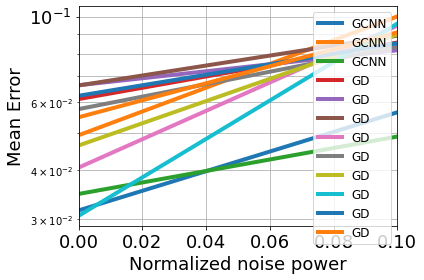

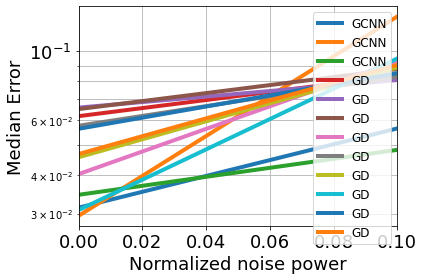

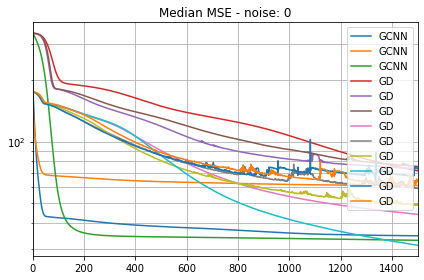

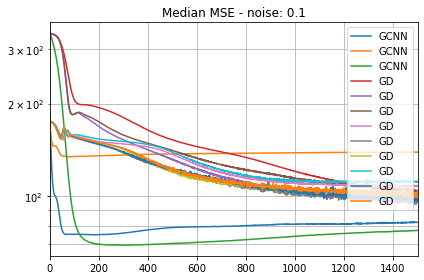

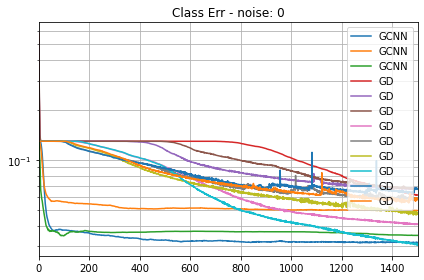

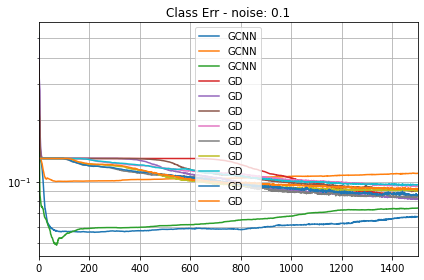

In [22]:
best_mean_err, best_med_err, _, _ = get_best_err(err)
fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
fig4 = plot_noise_err(best_med_err, legend, 'Median Error')
# fig3.savefig(PATH + 'denoise_temp_all_pn.eps')
# fig4.savefig(PATH + 'denoise_temp_all_pn.eps')

print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)
print('Err all 0:', np.sum(x)/x.size)

print_err(best_mean_err, weights)

# mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse)
print_err(best_mean_mse, weights)

figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')
figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')


## Using signal associtated with label 0 - As Class problem

In [42]:
N_P = [0, .1]
lr = 0.001
loss=nn.CrossEntropyLoss
Exps = [

        

        # {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'legend': 'GAT'},
    
        # [[300, 1000], [400, 1000], [500, 1000], [750, 1000], [1000, 2000], [250, 500, 1500],
        #       [300, 1000, 2000], [400, 1000, 2000], [500, 1000, 2000]]

        # With SIGMOID
        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [400, 1000] + [G.N]*2, 'fts': [70]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},


        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 2, 'last_act': nn.ReLU(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000] + [G.N]*2, 'fts': [75]*3 + [2],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [1000, 2000] + [G.N]*2, 'fts': [75]*3 + [2],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [250, 500, 1500] + [G.N]*2, 'fts': [50]*4 + [2],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'loss': loss(reduction='none'), 'legend': 'GD'},


        # {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 2, 'last_act': None,
        #  'loss': loss(reduction='none'), 'legend': 'GCNN'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000] + [G.N]*2, 'fts': [75]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [1000, 2000] + [G.N]*2, 'fts': [75]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [250, 500, 1500] + [G.N]*2, 'fts': [50]*4 + [2],
        #  'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
        #  'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},



        # {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 2, 'last_act': nn.ReLU(),
        #  'loss': loss(reduction='none'), 'legend': 'GCNN'},
        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000] + [G.N]*2, 'fts': [75]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [1000, 2000] + [G.N]*2, 'fts': [75]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [250, 500, 1500] + [G.N]*2, 'fts': [50]*4 + [2],
        #  'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
        #  'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},



        # WITHOUT SIGMOID
        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000] + [G.N]*2, 'fts': [100]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},

        # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [500, 1000] + [G.N]*2, 'fts': [100]*3 + [2],
        #  'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
        #  'loss': loss(reduction='none'), 'legend': 'GD'},
        ]

# Model parameters
epochs =  100

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
H = utils.create_filter(S, h_params)
H_norm = H/np.linalg.norm(H)

# Compute needed matrices
for exp in Exps:
    if exp['type'] == '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
        # clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
        idx = clts_nodes.index(exp['nodes'])
        exp['nodes'] = clts[idx].sizes
        exp['Us'] = clts[idx].Us
        exp['As'] = clts[idx].As
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [44]:
n_signals = 10

x = np.zeros(G.N)
x[labels == 0] = 1

x_1hot = np.zeros((G.N, 2))
x_1hot[x == 1, 0] = 1
x_1hot[x != 1, 1] = 1

xx_nn = np.zeros((len(N_P), n_signals, G.N))
cross = np.zeros((len(N_P), n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):

        x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

        xx_nn[i,j,:] = x_n
        x_n_1hot = np.zeros((G.N, 2))
        x_n_1hot[x_n == 1, 0] = 1
        x_n_1hot[x_n != 1, 1] = 1

        for k, exp in enumerate(Exps):
            print(exp['legend'], end=' ')
            # Change arch to use 1hot input?
            model = select_model(exp, x_n_1hot, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                cross[i, j, k], err[i, j, k], _ = model.fit(x_n_1hot, x_1hot, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)

            print('j:', j, 'cross:', cross[i, j, k].min(), 'err rate:', err[i, j, k].min())

        # print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0
GCNN j: 0 cross: 452.89444284109527 err rate: 0.03951255459105596
GD WARNING: degree matrix is singular. N: 1000
j: 0 cross: 1370.2793776392937 err rate: 0.1296159501071088
GD WARNING: degree matrix is singular. N: 2000
j: 0 cross: 1458.1965593397617 err rate: 0.1296159501071088
GD WARNING: degree matrix is singular. N: 500
j: 0 cross: 1319.5746777057648 err rate: 0.1296159501071088
GD WARNING: degree matrix is singular. N: 1000
j: 0 cross: 1306.8704065680504 err rate: 0.1296159501071088
GCNN j: 1 cross: 287.3121196472389 err rate: 0.033604135212954134
GD WARNING: degree matrix is singular. N: 1000
j: 1 cross: 1370.9025293290615 err rate: 0.1296159501071088
GD WARNING: degree matrix is singular. N: 2000
j: 1 cross: 1494.0742576122284 err rate: 0.1296159501071088
GD WARNING: degree matrix is singular. N: 500
j: 1 cross: 1321.862648576498 err rate: 0.1296159501071088
GD WARNING: degree matrix is singular. N: 1000
j: 1 cross: 1317.4546340703964 err rate: 0.1296159501071088
GCNN j

In [ ]:
# x_1hot = np.zeros((G.N, 2))
# x_1hot[labels == 0, 0] = 1
# x_1hot[labels != 0, 1] = 1

# print(x.size, np.sum(x_1hot[:,0]==1), np.sum(x_1hot[:,1]==1))
# print(x.size, np.sum(x_n_1hot[:,0]==1), np.sum(x_n_1hot[:,1]==1))

In [ ]:
exp = Exps[2]
model_aux = select_model(exp, x_n, 500, lr, device)
x_hat = model.arch(model.arch.input).cpu().detach().numpy()
x_hat = np.argmax(x_hat, axis=1)

print(x_hat[:10])
print(x[:10])

print(np.sum(x_hat), np.sum(x))

print(np.sum(np.abs(x-x_hat))/G.N)


[1 1 1 1 1 1 1 1 1 1]
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
2708 351.0
0.870384047267356


Err all 0: 0.129615952732644
Err Noise: 0.10118168389955687
N_P: [0, 0.1]
GCNN (6077.0): 	0.0378	0.0511
GD (11400.0): 	0.1296	0.1296
GD (11400.0): 	0.1296	0.1296
GD (7600.0): 	0.1296	0.1296
GD (7600.0): 	0.1296	0.1296
N_P: [0, 0.1]
GCNN (6077.0): 	992.7959	1078.8218
GD (11400.0): 	1370.1179	1416.3149
GD (11400.0): 	1501.3900	1531.9430
GD (7600.0): 	1302.3163	1312.8878
GD (7600.0): 	1313.6518	1334.9874


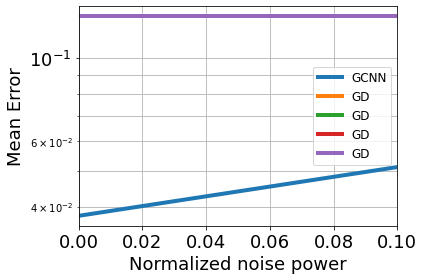

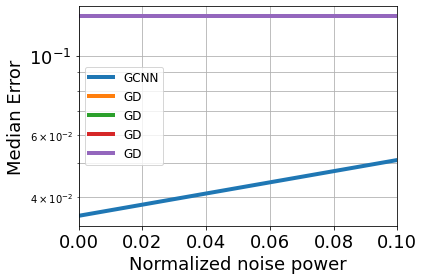

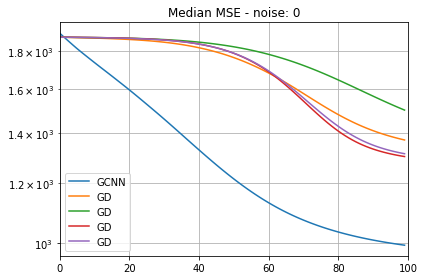

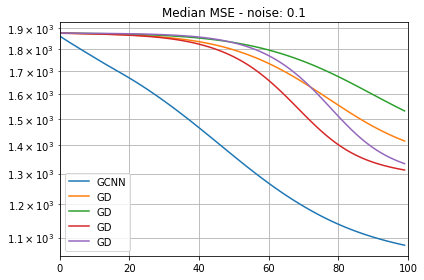

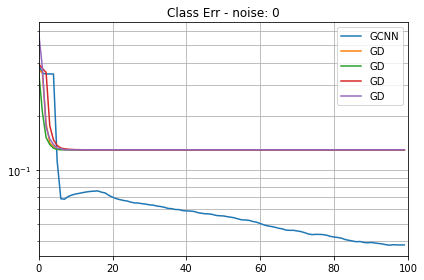

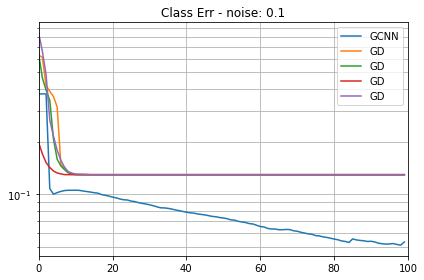

In [ ]:
best_mean_err, best_med_err, _, _ = get_best_err(err)
fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
fig4 = plot_noise_err(best_med_err, legend, 'Median Error')
# fig3.savefig(PATH + 'denoise_temp_all_pn.eps')
# fig4.savefig(PATH + 'denoise_temp_all_pn.eps')

print('Err all 0:', np.sum(x)/x.size)
print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)

print_err(best_mean_err, weights)

best_mean_cross, _, _, _ = get_best_err(cross)
print_err(best_mean_cross, weights)

figs = plot_iter_err(np.mean(cross, axis=1), 'Median MSE - noise')
figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')


In [ ]:
plt.show()

Err all 0: 0.129615952732644
Err Noise: 0.10118168389955687


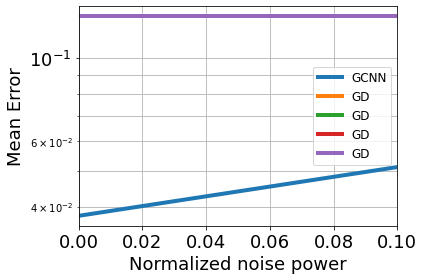

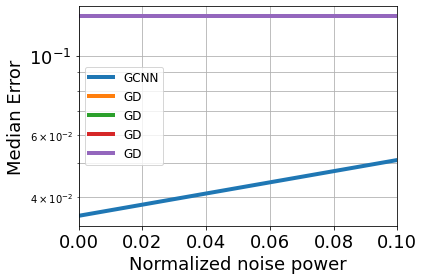

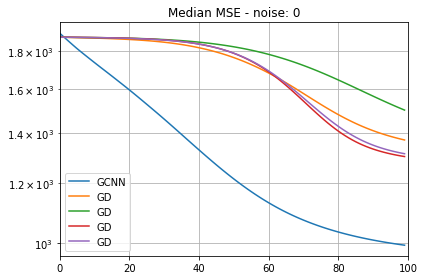

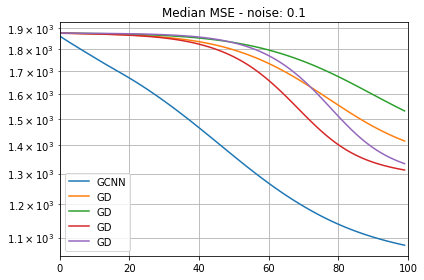

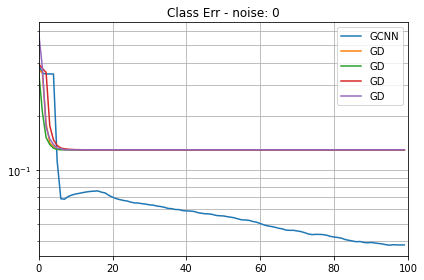

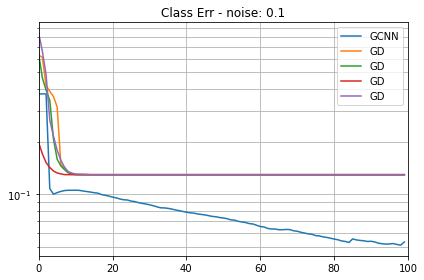

In [ ]:
best_mean_err, best_med_err, _, _ = get_best_err(err)
fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
fig4 = plot_noise_err(best_med_err, legend, 'Median Error')

print('Err all 0:', np.sum(x)/x.size)
print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)



figs = plot_iter_err(np.mean(cross, axis=1), 'Median MSE - noise')
figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')
